In [1]:
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import pandas as pd
import numpy as np
import time
import random
import datetime
import re #thư viện regular expressions để tìm kiếm, tách, thay thế chuỗi theo mẫu.

**Phần 1: Lấy dữ liệu sản phẩm từ trang web https://duoctinphong.com**

In [2]:
# Hàm xử lý giá: loại "VNĐ", bỏ dấu ngăn cách, chuyển về số
def parse_price(price_str):
    if not price_str:
        return None
    try:
        # Loại "VNĐ", dấu cách, và dấu chấm ngăn cách hàng nghìn
        cleaned = price_str.replace('VNĐ', '').replace('.', '').replace(',', '').strip()
        return int(cleaned)
    except:
        return None

my_data = []
visited_links = set() #Tạo một tập hợp (set) để lưu các đường link sản phẩm đã quét qua, tránh trùng lặp sản phẩm (một link chỉ thu thập 1 lần)

for page in range(1, 10):
    url = f"https://duoctinphong.com/san-pham/page/{page}/"
    data = requests.get(url)
    time.sleep(random.uniform(1, 3))

    html = BeautifulSoup(data.text, 'html.parser')
    danhsach = html.find_all('div', class_='product-small')

    for sanpham in danhsach:
        #Lấy danh mục sản phẩm
        category_tag = sanpham.find('p', class_='category')
        category = category_tag.text.strip() if category_tag else None

        #Lấy tên sản phẩm và URL chi tiết sản phẩm đảm bảo không bị trùng lặp
        title_tag = sanpham.find('a', class_='woocommerce-LoopProduct-link woocommerce-loop-product__link')
        if not title_tag:
            continue
        product_url = title_tag['href']
        if product_url in visited_links:
            continue
        visited_links.add(product_url)
        title = title_tag.text.strip()

        #Lấy giá sản phẩm kết hợp hàm parse_price ở trên để xử lý giá.
        price_tag = sanpham.find('span', class_='price')
        price_raw = price_tag.text.strip() if price_tag else None
        price = parse_price(price_raw)

        #Lấy countrating xử lý phần bỏ dấu (), chỉ lấy số lượt đánh giá
        countrating = sanpham.find('span', class_='cs-countrating')
        if countrating:
            text = countrating.text.strip()
            match = re.search(r'\((\d+)', text)  # Tìm số bên trong dấu ngoặc tròn ở đầu
            count_rating = int(match.group(1)) if match else 0
        else:
            count_rating = 0

        #Lấy số sao đánh giá
        rating_tag = sanpham.find('strong', class_='rating')
        if rating_tag:
            try:
                rating_star = float(rating_tag.text.strip())
            except:
                rating_star = None
        else:
            rating_star = None

        #Lấy dạng bào chế và quy cách đóng gói. Nếu chứa từ "Dạng bào chế", thì lấy phần sau dấu : làm giá trị cho dosage_form.
        #Nếu chưa từ "Quy cách đóng gói" thì lấy phần sau dấu : làm giá trị cho pack_size. Nếu không tìm thấy thì giữ là None.
        extra_info = sanpham.find('div', class_='cs-cateproinfo')
        dosage_form, pack_size = None, None
        if extra_info:
            spans = extra_info.find_all('span')
            for span in spans:
                text = span.text.strip()
                if 'Dạng bào chế' in text:
                    dosage_form = text.replace('Dạng bào chế:', '').strip()
                elif 'Quy cách đóng gói' in text:
                    pack_size = text.replace('Quy cách đóng gói:', '').strip()

        my_data.append({
            'category': category,
            'title': title,
            'price': price,
            'dosage_form': dosage_form,
            'pack_size': pack_size,
            'count_rating': count_rating,
            'rating_star': rating_star
        })

In [3]:
df = pd.DataFrame(my_data)
#Thêm cột discount và sales_price
conditions = [
    df['category'].str.contains('Thiết bị y tế', na=False),
    df['category'].str.contains('Mỹ phẩm', na=False),
    df['category'].str.contains('Thực phẩm bảo vệ sức khỏe', na=False)
]
discounts = [0.15, 0.20, 0.25]
df['discount'] = np.select(conditions, discounts, default=0.0)
df['sales_price'] = (df['price'] * (1 - df['discount'])).astype(int)

#Thêm cột tồn kho với giá trị giả lập cố định sau mỗi lần chạy
def generate_stock(title, min_stock=10, max_stock=500):
    return abs(hash(title)) % 500
df['stock'] = df['title'].apply(generate_stock)

#Thêm cột hạn sử dụng
def generate_expiry(title, start_date=datetime.date(2025, 6, 10), min_days=180, max_days=1080):
    delta_days = abs(hash(title)) % 1080
    expiry_date = start_date + datetime.timedelta(days=delta_days)
    return expiry_date
df['expiry_date'] = df['title'].apply(generate_expiry)
df['expiry_date'] = df['expiry_date'].apply(lambda d: d.strftime('%d/%m/%Y'))
df

,category,title,price,dosage_form,pack_size,count_rating,rating_star,discount,sales_price,stock,expiry_date
0,Thực phẩm bảo vệ sức khỏe,Thực phẩm bảo vệ sức khỏe Viên Ngậm Bổ Phế Kha...,43000,Viên ngậm.,Hộp 2 vỉ x 10 viên.,12,5.00,0.25,32250,340,15/07/2026
1,Thực phẩm bảo vệ sức khỏe,Thực phẩm bảo vệ sức khỏe Bổ phế Kha Tử Tín Ph...,48000,Dịch chiết lỏng,Lọ 125ml.,12,5.00,0.25,36000,347,15/10/2025
2,Thực phẩm bảo vệ sức khỏe,Thực phẩm bảo vệ sức khỏe Siro Tín Phong Xuyên...,50000,Cao lỏng,Hộp 60ml,10,5.00,0.25,37500,213,05/11/2026
3,Mỹ phẩm,Kem Đánh Răng Dược Liệu Ong Việt Trẻ Em,52000,Kem đánh răng,Tuýp 80g,14,4.93,0.20,41600,347,17/07/2027
4,Mỹ phẩm,Kem Đánh Răng Dược Liệu Ong Việt,60000,Kem đánh răng,Tuýp 150g,11,4.82,0.20,48000,0,30/07/2027
...,...,...,...,...,...,...,...,...,...,...,...
70,Thực phẩm bảo vệ sức khỏe,Thực phẩm bảo vệ sức khoẻ Evatinfo,580000,Viên nang mềm,Hộp 1 lọ 60 viên,12,4.83,0.25,435000,240,11/01/2027
71,Thực phẩm bảo vệ sức khỏe,Thực phẩm bảo vệ sức khỏe Estinfo,600000,Viên nang,Hộp 60 viên,12,5.00,0.25,450000,280,31/05/2027
72,Thực phẩm bảo vệ sức khỏe,Thực phẩm bảo vệ sức khỏe Hoàng Đại Bổ,650000,Cốm,Hộp lớn bao gồm 1 hộp ban ngày 15 gói * 4g và ...,0,0.00,0.25,487500,245,22/12/2027
73,Thực phẩm bảo vệ sức khỏe,Thực phẩm bảo vệ sức khỏe WhiteU20,790000,Viên nén bao phim,Hộp 30 viên,2,5.00,0.25,592500,221,08/11/2027


In [100]:
df.to_excel('duoctinphong_products.xlsx', index=False)

In [4]:
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   category      75 non-null     object 
 1   title         75 non-null     object 
 2   price         75 non-null     int64  
 3   dosage_form   71 non-null     object 
 4   pack_size     75 non-null     object 
 5   count_rating  75 non-null     int64  
 6   rating_star   75 non-null     float64
 7   discount      75 non-null     float64
 8   sales_price   75 non-null     int64  
 9   stock         75 non-null     int64  
 10  expiry_date   75 non-null     object 
dtypes: float64(2), int64(4), object(5)
memory usage: 6.6+ KB


,category,title,price,dosage_form,pack_size,count_rating,rating_star,discount,sales_price,stock,expiry_date
0,Thực phẩm bảo vệ sức khỏe,Thực phẩm bảo vệ sức khỏe Viên Ngậm Bổ Phế Kha...,43000,Viên ngậm.,Hộp 2 vỉ x 10 viên.,12,5.00,0.25,32250,340,15/07/2026
1,Thực phẩm bảo vệ sức khỏe,Thực phẩm bảo vệ sức khỏe Bổ phế Kha Tử Tín Ph...,48000,Dịch chiết lỏng,Lọ 125ml.,12,5.00,0.25,36000,347,15/10/2025
2,Thực phẩm bảo vệ sức khỏe,Thực phẩm bảo vệ sức khỏe Siro Tín Phong Xuyên...,50000,Cao lỏng,Hộp 60ml,10,5.00,0.25,37500,213,05/11/2026
3,Mỹ phẩm,Kem Đánh Răng Dược Liệu Ong Việt Trẻ Em,52000,Kem đánh răng,Tuýp 80g,14,4.93,0.20,41600,347,17/07/2027
4,Mỹ phẩm,Kem Đánh Răng Dược Liệu Ong Việt,60000,Kem đánh răng,Tuýp 150g,11,4.82,0.20,48000,0,30/07/2027


In [5]:
df['dosage_form'].fillna('Khác', inplace=True)

<ipython-input-5-5914f4e5f1d2>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['dosage_form'].fillna('Khác', inplace=True)


In [88]:
df.isnull().sum()

,0
category,0
title,0
price,0
dosage_form,0
pack_size,0
count_rating,0
rating_star,0
discount,0
sales_price,0
stock,0


Phân tích

category
Thực phẩm bảo vệ sức khỏe    49
Mỹ phẩm                      18
Thiết bị y tế                 8
Name: count, dtype: int64


<ipython-input-6-ae5d2d63a69f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=cat_counts.index, x=cat_counts.values, palette='Greens_d')


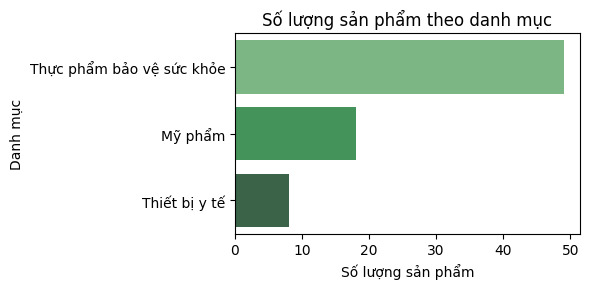

In [6]:
#đếm số lượng sản phẩm theo mỗi category
cat_counts = df['category'].value_counts()
print(cat_counts)
#Vẽ biểu đồ cột Số lượng sản phẩm theo mỗi category
plt.figure(figsize=(6, 3))
sns.barplot(y=cat_counts.index, x=cat_counts.values, palette='Greens_d')
plt.title('Số lượng sản phẩm theo danh mục')
plt.xlabel('Số lượng sản phẩm')
plt.ylabel('Danh mục')
plt.tight_layout()
plt.show()

In [7]:
#top 5 sản phẩm có nhiều đánh giá nhất
pd.set_option('display.expand_frame_repr', False)
top_5_reviews = df.sort_values(by='count_rating', ascending=False).head(5)
print(top_5_reviews[['title', 'count_rating', 'rating_star']])

                                                title  count_rating  rating_star
16          Thực phẩm bảo vệ sức khỏe Ích Huyết Khang            21         4.86
38                     Thực phẩm bảo vệ sức khoẻ ETDO            14         4.93
3             Kem Đánh Răng Dược Liệu Ong Việt Trẻ Em            14         4.93
12                                  Kem Bebi Chống Nẻ            13         4.77
34  Thực phẩm bảo vệ sức khỏe viên uống Tiêu Độc T...            13         4.62


In [8]:
#Tìm các sản phẩm có đánh giá 5 sao
pd.set_option('display.expand_frame_repr', False)
rated_5_star = df[df['rating_star'] == 5.0]
print(rated_5_star[['title', 'count_rating', 'rating_star']])

                                                title  count_rating  rating_star
0   Thực phẩm bảo vệ sức khỏe Viên Ngậm Bổ Phế Kha...            12          5.0
1   Thực phẩm bảo vệ sức khỏe Bổ phế Kha Tử Tín Ph...            12          5.0
2   Thực phẩm bảo vệ sức khỏe Siro Tín Phong Xuyên...            10          5.0
8         Thực phẩm bảo vệ sức khỏe Siro Ho Tinfolaps            10          5.0
10     Kem chống nắng Esunvy Sun Care SPF 50+/ PA++++            12          5.0
26  TPBVSK Viên uống Tiêu Độc Tín Phong (Hộp 5 vỉ ...             2          5.0
49             Thực phẩm bảo vệ sức khỏe Chogotin New             4          5.0
63                           WhiteU20 Whitening Toner             3          5.0
66                           WhiteU20 Whitening cream             1          5.0
71                  Thực phẩm bảo vệ sức khỏe Estinfo            12          5.0
73                 Thực phẩm bảo vệ sức khỏe WhiteU20             2          5.0
74                   Thực ph

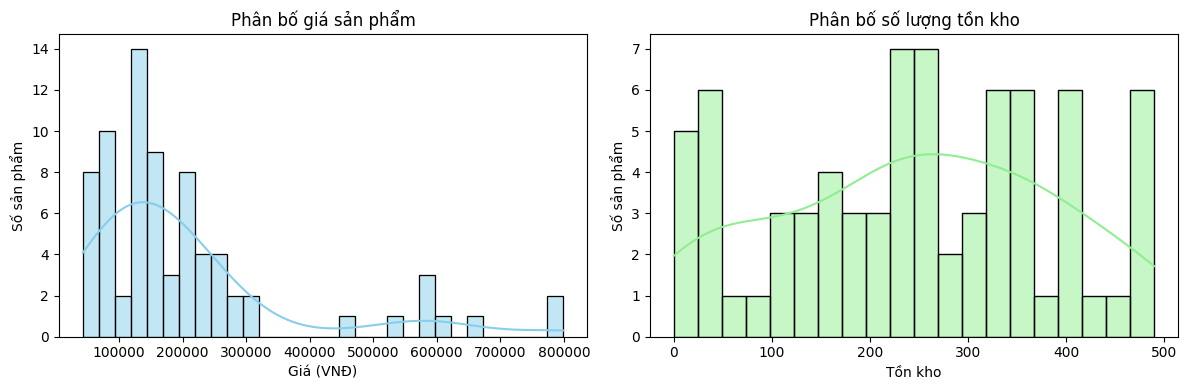

In [9]:
plt.figure(figsize=(12, 4))

# Biểu đồ 1: Phân bố giá sản phẩm
plt.subplot(1, 2, 1)
sns.histplot(df['price'].dropna(), bins=30, kde=True, color='skyblue')
plt.title('Phân bố giá sản phẩm')
plt.xlabel('Giá (VNĐ)')
plt.ylabel('Số sản phẩm')

# Biểu đồ 2: Phân bố tồn kho
plt.subplot(1, 2, 2)
sns.histplot(df['stock'], bins=20, kde=True, color='lightgreen')
plt.title('Phân bố số lượng tồn kho')
plt.xlabel('Tồn kho')
plt.ylabel('Số sản phẩm')

plt.tight_layout()
plt.show()

<ipython-input-10-e2533bd0afc4>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y='sales_price', palette='Blues', ax=axes[0])
<ipython-input-10-e2533bd0afc4>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y='stock', palette='Greens', ax=axes[1])


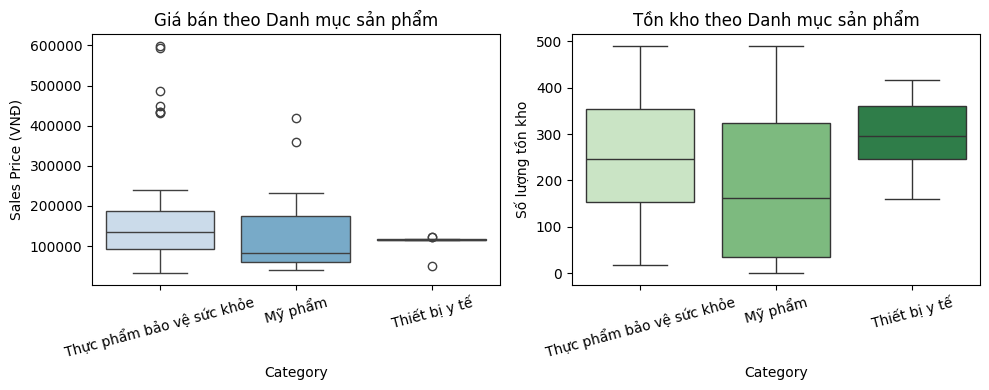

In [10]:
# Thiết lập figure gồm 1 hàng 2 cột
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=False)

# Boxplot: sales_price theo category
sns.boxplot(data=df, x='category', y='sales_price', palette='Blues', ax=axes[0])
axes[0].set_title('Giá bán theo Danh mục sản phẩm')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Sales Price (VNĐ)')
axes[0].tick_params(axis='x', rotation=15)

# Boxplot: stock theo category
sns.boxplot(data=df, x='category', y='stock', palette='Greens', ax=axes[1])
axes[1].set_title('Tồn kho theo Danh mục sản phẩm')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Số lượng tồn kho')
axes[1].tick_params(axis='x', rotation=15)

# Căn chỉnh layout
plt.tight_layout()
plt.show()

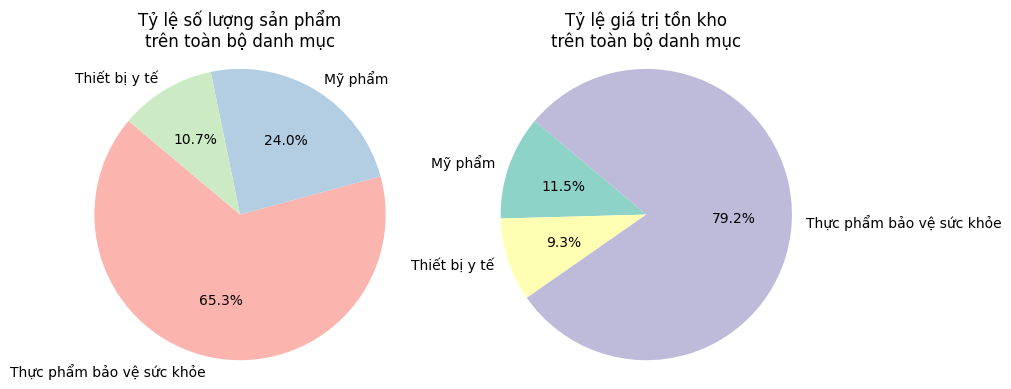

In [11]:
# Tính số lượng sản phẩm theo danh mục trên toàn bộ dữ liệu
category_counts = df['category'].value_counts()

# Tính tổng giá trị tồn kho theo danh mục (cần cột 'stock_value')
df['stock_value'] = df['stock'] * df['sales_price']
stock_value_by_category = df.groupby('category')['stock_value'].sum()

# Vẽ 2 biểu đồ tròn cạnh nhau
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Biểu đồ trái: Tỷ lệ số lượng sản phẩm
axes[0].pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Pastel1.colors
)
axes[0].set_title('Tỷ lệ số lượng sản phẩm\ntrên toàn bộ danh mục')

# Biểu đồ phải: Tỷ lệ giá trị tồn kho
axes[1].pie(
    stock_value_by_category,
    labels=stock_value_by_category.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Set3.colors
)
axes[1].set_title('Tỷ lệ giá trị tồn kho\ntrên toàn bộ danh mục')

# Làm cho biểu đồ là hình tròn
for ax in axes:
    ax.axis('equal')

plt.tight_layout()
plt.show()

In [12]:
from datetime import datetime
# Bước 1: Chuyển expiry_date về datetime
df['expiry_date_dt'] = pd.to_datetime(df['expiry_date'], format='%d/%m/%Y')

# Bước 2: Tính số ngày còn lại
today = datetime.today()
df['days_left'] = (df['expiry_date_dt'] - today).dt.days

# Bước 3: Lọc tồn kho > 300 và còn hạn dưới 12 tháng (~365 ngày)
filtered_df = df[(df['stock'] > 300) & (df['days_left'] < 365)]

# Bước 4: Sắp xếp theo tồn kho giảm dần và hiển thị top
top_products = filtered_df.sort_values(by='stock', ascending=False)

# Hiển thị kết quả
top_products[['title', 'category', 'stock', 'expiry_date', 'days_left', 'sales_price']].head(20)

,title,category,stock,expiry_date,days_left,sales_price
38,Thực phẩm bảo vệ sức khoẻ ETDO,Thực phẩm bảo vệ sức khỏe,490,27/11/2025,169,112500
44,Thực phẩm bảo vệ sức khỏe Visganic Plus,Thực phẩm bảo vệ sức khỏe,481,10/08/2025,60,135000
28,Dung dịch vệ sinh và dưỡng mắt Eyefresh,Thiết bị y tế,416,26/06/2025,15,114750
49,Thực phẩm bảo vệ sức khỏe Chogotin New,Thực phẩm bảo vệ sức khỏe,406,22/05/2026,345,150000
27,TPBVSK Nhỏ giọt Wizee Sắt,Thực phẩm bảo vệ sức khỏe,403,08/02/2026,242,97500
41,Thực phẩm bảo vệ sức khỏe Zimega-3 Kids,Thực phẩm bảo vệ sức khỏe,354,11/11/2025,153,120000
36,Miếng dán lưng – vai – gáy Doctor Tino – Hình ...,Thiết bị y tế,353,02/08/2025,52,123250
1,Thực phẩm bảo vệ sức khỏe Bổ phế Kha Tử Tín Ph...,Thực phẩm bảo vệ sức khỏe,347,15/10/2025,126,36000
25,Thực phẩm bảo vệ sức khỏe Cholesterol Tín Phong,Thực phẩm bảo vệ sức khỏe,335,25/06/2025,14,97500
29,Dung dịch xịt mũi Ectin người lớn,Thiết bị y tế,323,03/07/2025,22,114750


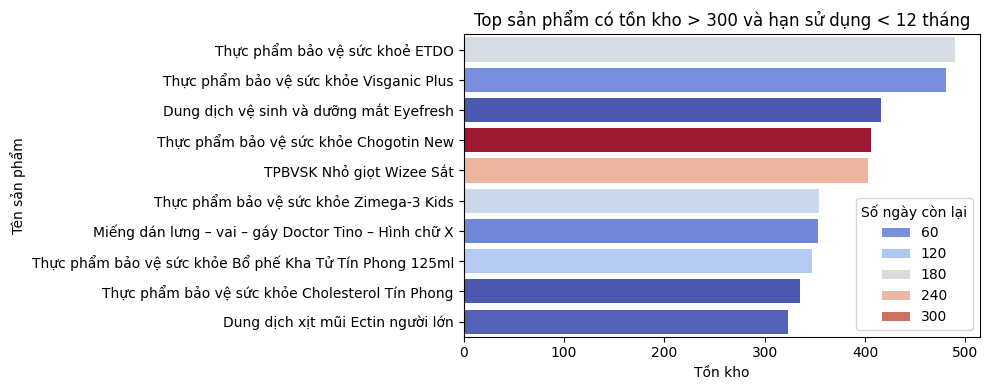

In [13]:
# Lấy top 10 sản phẩm có tồn kho cao nhất (sau khi đã lọc)
top_10 = top_products.sort_values(by='stock', ascending=False).head(10)

plt.figure(figsize=(10, 4))
sns.barplot(
    data=top_10,
    y='title',
    x='stock',
    hue='days_left',
    palette='coolwarm'
)
plt.title('Top sản phẩm có tồn kho > 300 và hạn sử dụng < 12 tháng')
plt.xlabel('Tồn kho')
plt.ylabel('Tên sản phẩm')
plt.legend(title='Số ngày còn lại')
plt.tight_layout()
plt.show()

In [14]:
# Lọc tồn kho > 300 và còn hạn dưới 6 tháng (180 ngày)
filtered_df = df[(df['stock'] > 300) & (df['days_left'] < 180)]

# Sắp xếp theo tồn kho giảm dần và hiển thị top
top_products = filtered_df.sort_values(by='stock', ascending=False)
top_products['stock_value'] = top_products['stock'] * top_products['sales_price']

# Hiển thị kết quả
top_products[['title', 'category', 'stock', 'expiry_date', 'days_left', 'sales_price', 'stock_value']].head(5)

,title,category,stock,expiry_date,days_left,sales_price,stock_value
38,Thực phẩm bảo vệ sức khoẻ ETDO,Thực phẩm bảo vệ sức khỏe,490,27/11/2025,169,112500,55125000
44,Thực phẩm bảo vệ sức khỏe Visganic Plus,Thực phẩm bảo vệ sức khỏe,481,10/08/2025,60,135000,64935000
28,Dung dịch vệ sinh và dưỡng mắt Eyefresh,Thiết bị y tế,416,26/06/2025,15,114750,47736000
41,Thực phẩm bảo vệ sức khỏe Zimega-3 Kids,Thực phẩm bảo vệ sức khỏe,354,11/11/2025,153,120000,42480000
36,Miếng dán lưng – vai – gáy Doctor Tino – Hình ...,Thiết bị y tế,353,02/08/2025,52,123250,43507250
